In [23]:
import numpy as np
from scipy.linalg import pinv

def ols(X, Y):
    return pinv(X.T @ X) @ X.T @ Y

n = 10000
Cx = np.array([[1, -.8], [-.8, 1.]])
X = np.random.multivariate_normal(np.zeros(2), Cx, n)
E = np.eye(2)
N = np.random.randn(n, 2) * 0
F = np.array([[1.], [3]])
Y = (X @ E + N) @ F

# JRR
G = ols(Y[::2], X[::2])
H = ols(X[1::2], Y[1::2] @ G)
print(np.diag(H))

[-0.26360939  1.26360939]


In [24]:
dim_x = len(X.T)
H = np.zeros((dim_x, dim_x))
for i in range(dim_x):
    not_i = [j for j in range(dim_x) if j != i]
    XY = np.c_[X[:, not_i], Y]
    G = ols(XY[::2], X[::2, i])
    H[i] = ols(X[1::2], XY[1::2] @ G)

print(np.diag(H))

[1. 1.]


In [26]:
dim_x = len(X.T)
H = np.zeros((dim_x, dim_x))
for i in range(dim_x):
    
    not_i = [j for j in range(dim_x) if j != i]
    XY = np.c_[X[:, not_i], Y]
    
    G_xy = ols(XY[::2], X[::2, i])
    X_hat_xy = XY[1::2] @ G_xy
    
    G_y = ols(Y[::2], X[::2, i])
    X_hat_y = Y[1::2] @ G_y
    
    G_x = ols(X[::2][:, not_i], X[::2, i])
    X_hat_x = X[1::2][:, not_i] @ G_x
    
    X_hat = (X_hat_xy + X_hat_y - X_hat_x) / 2.
    
    H[i] = ols(X[1::2], X_hat)

print(np.diag(H))

[0.36819531 1.13180469]


100%|██████████| 2/2 [00:00<00:00, 43.47it/s]

not causal p_value: 0.3010


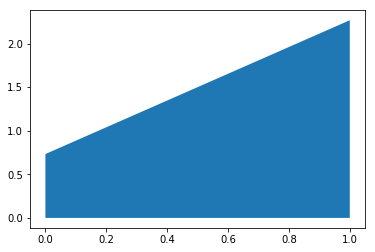

In [27]:
alphas = np.logspace(-3, 3, 10)
X_hat = np.zeros_like(X)
for i in trange(dim_x):
    not_i = [j for j in range(dim_x) if j != i]
    XY = np.c_[X[:, not_i], Y]
    # pick optimal alpha for ridge(Y, Xi)
    _, best, X_hat[:, [i, ]] = ridge_cv(XY, X[:, [i, ]], alphas)
    # apply ridge(XY, Xi, alpha)
    X_hat[:, [i, ]] += ridge_cv(Y, X[:, [i, ]], alphas[best])[2]
    X_hat[:, [i, ]] -= ridge_cv(X[:, not_i], X[:, [i, ]], alphas[best])[2]
E_hat, _, _ = ridge_cv(X, X_hat, alphas)
plt.fill_between(range(X.shape[1]), np.diag(E_hat))
not_causal = np.diag(E) > 0
_, p_value = ttest_1samp(np.diag(E_hat)[not_causal], 0)
print('not causal p_value: %.4f' % p_value)

not causal > 0: p_value=0.0000


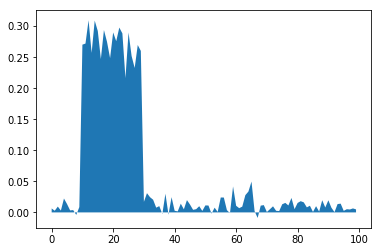

In [29]:
from tqdm import tqdm
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
from sklearn.preprocessing import scale
from scipy.linalg import pinv, svd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from tqdm import trange

%matplotlib inline


def make_data(seed=0):
    np.random.seed(seed)

    # make data
    n = 1000  # number of samples
    dim_x = 100  # dimensionality of X
    dim_y = 101

    Cx = np.random.randn(dim_x, dim_x)
    Cx = Cx.dot(Cx.T) / dim_x  # sym pos-semidefin

    X = np.random.multivariate_normal(np.zeros(dim_x), Cx, n)
    N = np.random.randn(n, dim_x)
    F = np.random.randn(dim_y, dim_x)
    E = np.eye(dim_x)
    E[:10] = 0
    E[30:] = 0

    Y = (X @ E + N) @ F.T
    Y += np.random.randn(*Y.shape)
    return scale(X), scale(Y), E


# make data
X, Y, E = make_data()
n_samples, dim_x = X.shape

alphas = np.logspace(-3, 3, 10)
ols = LinearRegression(fit_intercept=False)
ridge_cv = RidgeCV(alphas=alphas, fit_intercept=False)

def ridge_cv(X, Y, alphas, independent_alphas=False):
    """
    Similar to sklearn RidgeCV but
    (1) optimize a different alpha for each column of Y
    (2) return leave-one-out Y_hat
    """
    if isinstance(alphas, (float, int)):
        alphas = np.array([alphas, ], np.float64)
    n, n_x = X.shape
    n, n_y = Y.shape
    # Decompose X
    U, s, _ = svd(X, full_matrices=0)
    v = s**2
    UY = U.T @ Y

    # For each alpha, solve leave-one-out error coefs
    cv_duals = np.zeros((len(alphas), n, n_y))
    cv_errors = np.zeros((len(alphas), n, n_y))
    for alpha_idx, alpha in enumerate(alphas):
        # Solve
        w = ((v + alpha) ** -1) - alpha ** -1
        c = U @ np.diag(w) @ UY + alpha ** -1 * Y
        cv_duals[alpha_idx] = c

        # compute diagonal of the matrix: dot(Q, dot(diag(v_prime), Q^T))
        G_diag = (w * U ** 2).sum(axis=-1) + alpha ** -1
        error = c / G_diag[:, np.newaxis]
        cv_errors[alpha_idx] = error

    # identify best alpha for each column of Y independently
    if independent_alphas:
        best_alphas = (cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = np.transpose([cv_duals[b, :, i]
                              for i, b in enumerate(best_alphas)])
        cv_errors = np.transpose([cv_errors[b, :, i]
                                  for i, b in enumerate(best_alphas)])
    else:
        _cv_errors = cv_errors.reshape(len(alphas), -1)
        best_alphas = (_cv_errors ** 2).mean(axis=1).argmin(axis=0)
        duals = cv_duals[best_alphas]
        cv_errors = cv_errors[best_alphas]

    coefs = duals.T @ X
    Y_hat = Y - cv_errors
    return coefs, best_alphas, Y_hat

# Standard JRR
# H = ridge(Y, X)
_, _, X_hat = ridge_cv(Y, X, alphas, True)
E_hat, _, _ = ridge_cv(X, X_hat, alphas)
jrr = E_hat
plt.fill_between(range(X.shape[1]), np.diag(E_hat))

not_causal = np.diag(E) == 0
_, p_value = ttest_1samp(np.diag(E_hat)[not_causal], 0)
print('not causal > 0: p_value=%.4f' % p_value)

100%|██████████| 100/100 [00:06<00:00, 14.52it/s]


not causal p_value: 0.0000


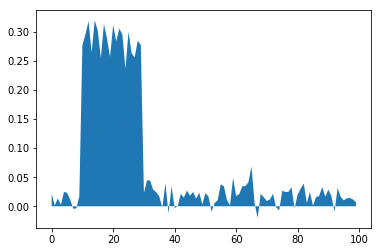

In [30]:
alphas = np.logspace(-3, 3, 10)
X_hat = np.zeros_like(X)
for i in trange(dim_x):
    not_i = [j for j in range(dim_x) if j != i]
    XY = np.c_[X[:, not_i], Y]
    # pick optimal alpha for ridge(Y, Xi)
    _, best, X_hat[:, [i, ]] = ridge_cv(XY, X[:, [i, ]], alphas)
    # apply ridge(XY, Xi, alpha)
    X_hat[:, [i, ]] += ridge_cv(Y, X[:, [i, ]], alphas[best])[2]
    X_hat[:, [i, ]] -= ridge_cv(X[:, not_i], X[:, [i, ]], alphas[best])[2]
E_hat, _, _ = ridge_cv(X, X_hat, alphas)
plt.fill_between(range(X.shape[1]), np.diag(E_hat))
not_causal = np.diag(E) > 0
_, p_value = ttest_1samp(np.diag(E_hat)[not_causal], 0)
print('not causal p_value: %.4f' % p_value)

not causal > 0: p_value=0.3840


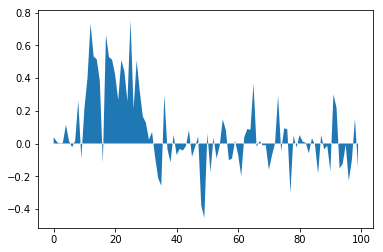

In [31]:
from sklearn.decomposition import PCA
pca = PCA('mle').fit(X)
Xt = pca.inverse_transform(pca.transform(X))
E_hat = pinv(Xt.T @ Xt) @ Xt.T @ X_hat

plt.fill_between(range(X.shape[1]), np.diag(E_hat))
not_causal = np.diag(E) == 0
_, p_value = ttest_1samp(np.diag(E_hat)[not_causal], 0)
print('not causal > 0: p_value=%.4f' % p_value)